In [1]:
! pip install -U git+https://github.com/Adapter-Hub/adapter-transformers.git
! pip install datasets

  Cloning https://github.com/Adapter-Hub/adapter-transformers.git to /tmp/pip-req-build-vzm3677l
  Running command git clone -q https://github.com/Adapter-Hub/adapter-transformers.git /tmp/pip-req-build-vzm3677l
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for adapter-transformers: filename=adapter_transformers-2.0.1-cp37-none-any.whl size=2099116 sha256=8d7f0d9d43237be3f855fde87cd67d16502b372f5f562da7999580de2ce7d195
  Stored in directory: /tmp/pip-ephem-wheel-cache-4vpyv6vy/wheels/b0/56/c9/5bf1c51cd513412090ad751ab10fc025210176bf0a82dd8af3
Successfully built adapter-transformers
  Found existing installation: adapter-transformers 2.0.1
    Uninstalling adapter-transformers-2.0.1:
      Successfully uninstalled adapter-transformers-2.0.1


In [2]:
cd drive/MyDrive/CAMemBERT-Adapters/

/content/drive/MyDrive/CAMemBERT-Adapters


Using custom data configuration default-81dea1c6fae1de7d


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-81dea1c6fae1de7d/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


Epoch,Training Loss,Validation Loss,Loss,Spearmanr,Cohen Kappa,Pearsonr
1,No log,2.735668,2.749690,0.933443,0.362098,0.890950
2,No log,2.709466,2.719088,0.941492,0.360270,0.943953
3,No log,0.060500,0.043268,0.944670,0.334593,0.907856
4,No log,0.024313,0.005142,0.946629,0.448206,0.949987
5,No log,0.023300,0.002978,0.943577,0.431024,0.956891


{'train_loss': 2.7496895790100098, 'train_spearmanr': 0.9555949340781668, 'train_cohen_kappa': 0.42507081146004444, 'train_pearsonr': 0.8836768010191826, 'eval_loss': 2.7356679439544678, 'eval_spearmanr': 0.9334433090717049, 'eval_cohen_kappa': 0.362098138747885, 'eval_pearsonr': 0.8909495393853732}
{'train_loss': 2.719087600708008, 'train_spearmanr': 0.9768222838632676, 'train_cohen_kappa': 0.526713961144341, 'train_pearsonr': 0.9585725681642604, 'eval_loss': 2.709465503692627, 'eval_spearmanr': 0.941492462856914, 'eval_cohen_kappa': 0.36027048741296186, 'eval_pearsonr': 0.9439526296641674}
{'train_loss': 0.04326750338077545, 'train_spearmanr': 0.9763989186272437, 'train_cohen_kappa': 0.391990984083582, 'train_pearsonr': 0.9444735971746351, 'eval_loss': 0.06050047650933266, 'eval_spearmanr': 0.9446698177474799, 'eval_cohen_kappa': 0.3345934462974425, 'eval_pearsonr': 0.9078561661307116}
{'train_loss': 0.005142445210367441, 'train_spearmanr': 0.9919559444866747, 'train_cohen_kappa': 0.

{'eval_loss': 0.026611430570483208, 'eval_spearmanr': 0.9582989659170547, 'eval_cohen_kappa': 0.3476870603282881, 'eval_pearsonr': 0.9140189563243709}
_________plotting history__________
defaultdict(<class 'list'>, {('_loss', 'train'): [2.7496895790100098, 2.719087600708008, 0.04326750338077545, 0.005142445210367441, 0.0029777607414871454], ('_spearmanr', 'train'): [0.9555949340781668, 0.9768222838632676, 0.9763989186272437, 0.9919559444866747, 0.997534309776671], ('_cohen_kappa', 'train'): [0.42507081146004444, 0.526713961144341, 0.391990984083582, 0.7141743531596988, 0.8086938703277665], ('_pearsonr', 'train'): [0.8836768010191826, 0.9585725681642604, 0.9444735971746351, 0.9891381741522052, 0.9936728526773313], ('_loss', 'eval'): [2.7356679439544678, 2.709465503692627, 0.06050047650933266, 0.024312522262334824, 0.02329983375966549], ('_spearmanr', 'eval'): [0.9334433090717049, 0.941492462856914, 0.9446698177474799, 0.9466285989117518, 0.9435770823059677], ('_cohen_kappa', 'eval'): [0

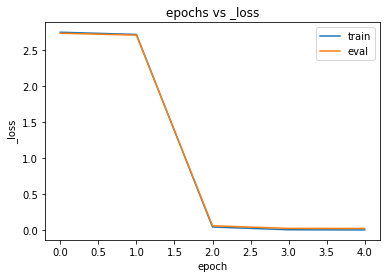

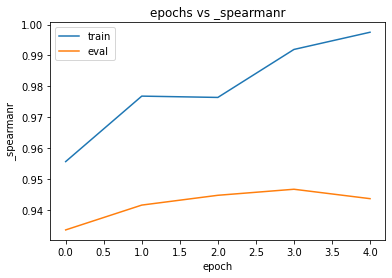

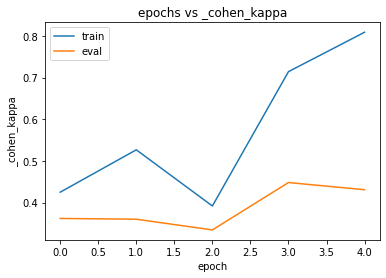

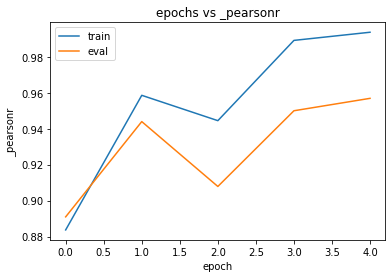

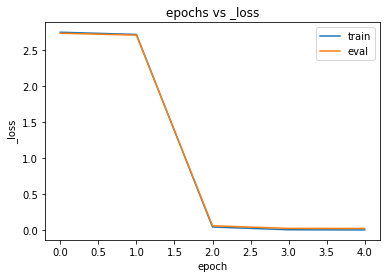

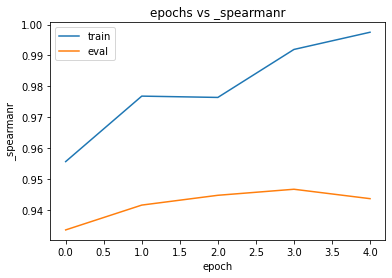

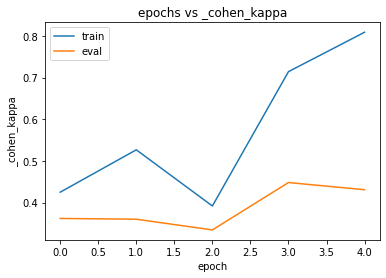

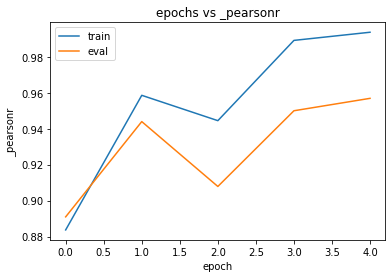

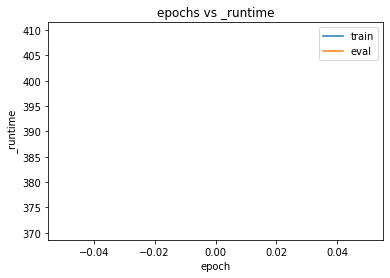

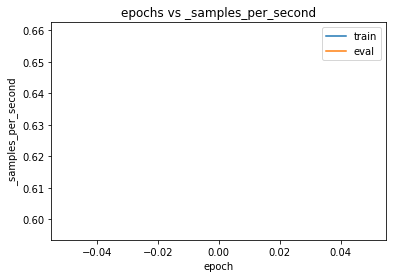

In [14]:
from transformers import AutoTokenizer,EarlyStoppingCallback,TrainingArguments
from datasets import load_dataset,load_metric
from src.utils.preprocessing import read_pickle_file
from src.models.transformer_models import R2BERT
from src.models.trainers import R2Trainer
from src.models.running import *
from sklearn.metrics import r2_score,cohen_kappa_score
import torch

def encode_batch(batch):
  """Encodes a batch of input data using the model tokenizer."""
  return tokenizer(batch[tokenize_col], max_length=max_n_tokens, truncation=True, padding="max_length")

def compute_metrics(p):
    #####################################################
    # Here is where the error lies p.predictions returns only 30 
    # predictions for the training arguments and parameters set below
    logits, labels = p.predictions,p.label_ids
    metrics_dic = metric.compute(predictions=logits, references=labels)
    metrics_dic['cohen_kappa'] = cohen_kappa_score(logits,labels)
    metrics_dic['pearsonr'] = r2_score(labels, logits)
    return metrics_dic

es = 2
lr = 4e-5
bs = 16
epochs = 5
frozen_layers = 1
metric_for_best_model = 'pearsonr'
dev = True

tokenize_col='essay'
max_n_tokens=512
extra_cols_for_dataset=['essay_set','norm_scores']

params = generate_parameters(es,lr,bs,epochs,frozen_layers,metric_for_best_model,dev,max_n_tokens)

pre_trained_model_name = 'bert-base-uncased'
dataset_title = 'asap'
task = 'aes'
subtask = 'regression'
abrev_name = f'r2_bert_{dataset_title}'

file_paths = generate_file_paths(dataset_title,task,subtask,params,abrev_name)

dataset_dic = {'train':file_paths['train_file_path'],'test':file_paths['test_file_path'],'val':file_paths['val_file_path']}

dataset = load_dataset('csv', data_files=dataset_dic)
tokenizer = AutoTokenizer.from_pretrained(pre_trained_model_name)
dataset = dataset.map(encode_batch, batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask","labels"]+extra_cols_for_dataset)

min_max_dic = read_pickle_file(f'{file_paths["pickle_files"]}nomalised_params.pickle')

model = R2BERT(pre_trained_model_name,norm_params=min_max_dic,dynamic=True)
model.set_trainable_params(params['frozen_layers'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

metric = load_metric("spearmanr")

training_args = base_training_args(params,file_paths)

callbacks = [EarlyStoppingCallback(es)]

trainer = R2Trainer(model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    compute_metrics=compute_metrics,
    callbacks=callbacks,)

trainer.train()

print()
print('__________test set results__________')
trainer.evaluate(dataset['test'],testing=True)
hist = trainer.state.log_history[-1]
eval_data = generate_eval_data(hist,params,task,subtask,pre_trained_model_name)
update_evaluation_results_for_this_model(f'{file_paths["evaluation_file_this_model"]}',eval_data)
update_evaluation_results_for_subtask(file_paths)

print('_________plotting history__________')
trainer.plot_history(file_paths['plots_path'],f'{file_paths["full_model_name"]}')

In [13]:
import pandas as pd
pd.read_csv(file_paths['train_file_path'])

,Unnamed: 0,essay_id,essay_set,essay,labels,norm_scores
0,5665,4595,2,I believe that they should leave leave them on...,3,0.400000
1,503,12716,5,In this memoir the mood was created Narciso an...,2,0.500000
2,5768,8924,4,The author chose to conclude the story with th...,2,0.666667
3,4664,358,1,"Dear @CAPS1 of the @ORGANIZATION1, I personaly...",7,0.500000
4,2202,6666,3,The cyclist had to deal with some tough terrai...,2,0.666667
...,...,...,...,...,...,...
773,2096,19281,7,A time I had to be patient was when my dad was...,17,0.681818
774,2783,636,1,"Dear local newspaper, I feel that computers ar...",9,0.700000
775,4083,18492,7,I was patient before; I went hunting with my d...,17,0.681818
776,207,1767,1,"Guaranteed, @NUM1 years from now we will still...",9,0.700000
